In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy import optimize

In [2]:
WIDTH = 32
HEIGHT = 32

X_train = np.array(pd.read_csv('X_train.csv', header=None, sep=',', usecols=range(3*WIDTH*HEIGHT)))
y_train = np.array(pd.read_csv('y_train.csv', header='infer', sep=','))[:, 1]  # discard the id column
classes = np.unique(y_train)

X_test = np.array(pd.read_csv('X_test.csv', header=None, sep=',', usecols=range(3*WIDTH*HEIGHT)))

In [3]:
RGB2GREY = [0.2989, 0.5870, 0.1140]

def preprocess(X, to_grey=False):
    X = X.reshape(-1, 3, WIDTH, HEIGHT).transpose(0, 2, 3, 1)
    X -= X.min(axis=(0, 1, 2))
    X /= X.max(axis=(0, 1, 2))
    if to_grey:
        return (X @ RGB2GREY).reshape(-1, WIDTH*HEIGHT)
    return X.transpose(0, 3, 1, 2).reshape(-1, 3*WIDTH*HEIGHT)

def split_train_set(X, y, classes, val_size=0.2, seed=None):
    rng = np.random.default_rng(seed)
    
    nb_examples = len(y) // len(classes)
    val_examples = int(val_size * nb_examples)
    
    class_indices = np.zeros((len(classes), nb_examples), dtype=int)
    for i, class_ in enumerate(classes):
        class_indices[i] = np.argwhere(y == class_).ravel()
    
    val_indices = rng.choice(
        class_indices,
        size=val_examples,
        replace=False,
        axis=1
    )
    
    train_indices = np.zeros((len(classes), nb_examples - val_examples), dtype=int)
    for i in range(len(classes)):
        train_indices[i] = np.setdiff1d(
            class_indices[i],
            val_indices[i],
            assume_unique=True
        )
    
    train_indices = rng.permutation(train_indices.ravel())
    val_indices = rng.permutation(val_indices.ravel())
    
    return X_train[train_indices], y_train[train_indices], \
            X_train[val_indices], y_train[val_indices]
    
X_train, y_train, X_val, y_val = split_train_set(
    X_train,
    y_train,
    classes,
    seed=12345
)
X_train = preprocess(X_train, to_grey=True)
X_val = preprocess(X_val, to_grey=True)
X_test = preprocess(X_test, to_grey=True)

[]

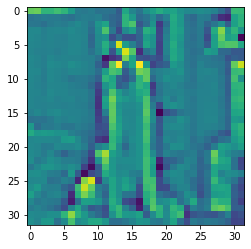

In [4]:
plt.imshow(X_train[4].reshape(WIDTH, HEIGHT))
plt.plot()

# SVM

In [5]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel

    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        dists = np.square(X)[:, np.newaxis].sum(axis=2) - 2*X @ Y.T + np.square(Y).sum(axis=1)
        return np.exp(-dists/(2*sigma**2))    ## Matrix of shape NxM
    
class Linear:
    def __init__(self):
        pass

    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T ## Matrix of shape NxM

In [6]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon=1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.support = None
        self.epsilon = epsilon

    def fit(self, X, y, K_sim):
       #### You might define here any variable needed for the rest of the code
        N = len(y)

        # Lagrange dual problem
        def loss(alpha):
            alpha_y = alpha * y
            return -alpha.sum() + (1/2) * alpha_y @ K_sim @ alpha_y

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return -np.ones(N) + (y.reshape(-1, 1) * K_sim) @ (alpha * y)


        # '''----------------function defining the equality constraint------------------'''
        fun_eq = lambda alpha: np.dot(alpha, y)
        #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        jac_eq = lambda alpha: y
        # '''---------------function defining the inequality constraint-------------------'''
#         fun_ineq = lambda alpha: np.hstack((np.zeros(N), self.C*np.ones(N))) + np.hstack((alpha, -alpha))
        # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
#         jac_ineq = lambda alpha: np.vstack((np.eye(N), -np.eye(N)))
        
        constraints = (
            {'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
#             {'type': 'ineq', 'fun': fun_ineq , 'jac': jac_ineq}
        )
        
        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha),
                                   bounds=((0, self.C),) * N,
                                   constraints=constraints)
        self.alpha = optRes.x
        
        ## Assign the required attributes
        supportIndices = np.argwhere(np.abs(self.alpha) <= self.epsilon).ravel()
        self.support = X[supportIndices]
        self.beta = y[supportIndices] * self.alpha[supportIndices]
        
        b_indices = np.intersect1d(supportIndices, np.argwhere(self.alpha >= self.C - self.epsilon).ravel())
        
        self.b = np.mean(y[b_indices] - K_sim[np.ix_(b_indices, supportIndices)] @ self.beta)


    def predict(self, X):
        """ Predict y values before thresholding """
        return self.b + self.kernel(x, self.support) @ self.beta

In [7]:
class KernelSVMC:
    
    def __init__(self, C, kernel, classes, epsilon=1e-3):
        self.type = 'non-linear'
        self.C = C
        self.kernel = kernel
        self.classes = classes
        self.epsilon = epsilon
        self.binary_classifiers = []

    def fit(self, X, y):
        K_sim = self.kernel(X, X)
        print(f'Finished computing the similarity matrix!')
        for i, class_ in enumerate(self.classes):
            model = KernelSVC(self.C, self.kernel, self.epsilon)
            model.fit(X, np.where(y == class_, 1, -1), K_sim)
            self.binary_classifiers.append(model)
            print(f'Finished class {class_} vs the rest')


    def predict(self, X):
        """ Predict y values before thresholding """
        predictions = np.zeros((X.shape[0], len(self.classes)))
        for i, model in enumerate(self.binary_classifiers):
            predictions[:, i] = model.predict(X)
        return self.classes[predictions.argmax(axis=1)]

In [ ]:
C = 10000.
linear_kernel = Linear().kernel
model = KernelSVMC(C=C, kernel=linear_kernel, classes=classes)
model.fit(X_train, y_train)
predicted = model.predict(X_train)

Finished computing the similarity matrix!


In [ ]:
C = 10000.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[0])

C = 10.
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax = ax[1])


sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training', ax=ax[2])